In [125]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


PATH = "MSFT.csv"
BATCH_SIZE = 64
HORIZON = 1
WINDOW_SIZE = 7

def import_dataset(path):
    return pd.read_csv(path, parse_dates=['Date'])

def get_labelled_windows(x, horizon):
    return x[:, :-horizon], x[:, -horizon][:, 1]

def make_windows(x, window_size, horizon):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon+1)), axis=0).T
    windowed_array = x[window_indexes]
    windows, label = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, label

def train_test_split(X, y, test_size=0.2):
    X_train = X[:int(len(X)*(1-test_size))]
    y_train = y[:int(len(y)*(1-test_size))]
    X_test = X[int(len(X)*(1-test_size)):]
    y_test = y[int(len(y)*(1-test_size)):]
    return X_train, y_train, X_test, y_test

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(WINDOW_SIZE, activation='relu'),
        tf.keras.layers.LSTM(64, recurrent_dropout=0.2, return_sequences=True,
                             input_shape=(X_train.shape[1],X_train.shape[2])),
        tf.keras.layers.LSTM(128, recurrent_dropout=0.2, return_sequences=False),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(HORIZON)
    ])
    return model

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              monitor='val_loss',
                                              mode='min',
                                              save_best_only=True)  # save only the best model to file


callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', min_lr=1e-10, patience=2, mode='min', factor=0.1),
    create_model_checkpoint(model_name='model')
    ]



In [126]:
df = import_dataset(PATH)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-10,56.718750,56.843750,55.687500,56.125000,35.104012,44963600
1,2000-01-11,55.750000,57.125000,54.343750,54.687500,34.204887,46743600
2,2000-01-12,54.250000,54.437500,52.218750,52.906250,33.090797,66532400
3,2000-01-13,52.187500,54.312500,50.750000,53.906250,33.716267,83144000
4,2000-01-14,53.593750,56.968750,52.875000,56.125000,35.104012,73416400
...,...,...,...,...,...,...,...
5761,2022-12-01,253.869995,256.119995,250.919998,254.690002,254.690002,26041500
5762,2022-12-02,249.820007,256.059998,249.690002,255.020004,255.020004,21522800
5763,2022-12-05,252.009995,253.820007,248.059998,250.199997,250.199997,23435300
5764,2022-12-06,250.820007,251.860001,243.779999,245.119995,245.119995,22463700


In [127]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-10,56.718750,56.843750,55.687500,56.125000,35.104012,44963600
1,2000-01-11,55.750000,57.125000,54.343750,54.687500,34.204887,46743600
2,2000-01-12,54.250000,54.437500,52.218750,52.906250,33.090797,66532400
3,2000-01-13,52.187500,54.312500,50.750000,53.906250,33.716267,83144000
4,2000-01-14,53.593750,56.968750,52.875000,56.125000,35.104012,73416400
...,...,...,...,...,...,...,...
5761,2022-12-01,253.869995,256.119995,250.919998,254.690002,254.690002,26041500
5762,2022-12-02,249.820007,256.059998,249.690002,255.020004,255.020004,21522800
5763,2022-12-05,252.009995,253.820007,248.059998,250.199997,250.199997,23435300
5764,2022-12-06,250.820007,251.860001,243.779999,245.119995,245.119995,22463700


In [128]:
train_dates = df['Date']
df = df.set_index('Date')
cols = df.columns[0:5]
df = MinMaxScaler(feature_range=(0,1)).fit_transform(df.iloc[:, :5])

In [129]:
pd.DataFrame(df, columns = cols)

,Open,High,Low,Close,Adj Close
0,0.126036,0.123406,0.124698,0.124939,0.072139
1,0.123095,0.124248,0.120593,0.120556,0.069402
2,0.118542,0.116203,0.114101,0.115125,0.066011
3,0.112281,0.115828,0.109614,0.118174,0.067915
4,0.116550,0.123780,0.116106,0.124939,0.072139
...,...,...,...,...,...
5761,0.724516,0.719952,0.721138,0.730394,0.740549
5762,0.712222,0.719772,0.717380,0.731400,0.741554
5763,0.718870,0.713067,0.712400,0.716703,0.726882
5764,0.715257,0.707199,0.699325,0.701214,0.711418


In [130]:
df

array([[0.12603591, 0.12340592, 0.12469831, 0.12493902, 0.07213915],
       [0.12309514, 0.12424786, 0.12059313, 0.12055587, 0.06940225],
       [0.11854168, 0.11620266, 0.11410121, 0.11512456, 0.06601101],
       ...,
       [0.71886952, 0.7130669 , 0.7124003 , 0.71670328, 0.72688163],
       [0.71525715, 0.7071995 , 0.69932481, 0.70121358, 0.71141834],
       [0.69707366, 0.69013619, 0.69452845, 0.69892672, 0.70913537]])

In [131]:
df.shape

(5766, 5)

In [132]:
total_windows, total_labels = make_windows(df, WINDOW_SIZE, HORIZON)
X_train, y_train, X_test, y_test = train_test_split(total_windows, total_labels)
model_2_lstm = build_model()
model_2_lstm.compile(loss = 'mse',
                     optimizer = tf.keras.optimizers.Adam(1e-3),
                     metrics=['mse'])
history = model_2_lstm.fit(X_train, y_train, validation_split=0.1, epochs=50, callbacks=[callbacks], batch_size=BATCH_SIZE)

Epoch 1/50
65/65 [==============================] - 12s 125ms/step - loss: 1.6665e-04 - mse: 1.6665e-04 - val_loss: 3.4641e-05 - val_mse: 3.4641e-05 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 8s 122ms/step - loss: 2.3301e-05 - mse: 2.3301e-05 - val_loss: 2.0344e-05 - val_mse: 2.0344e-05 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 3s 46ms/step - loss: 1.8522e-05 - mse: 1.8522e-05 - val_loss: 6.5891e-05 - val_mse: 6.5891e-05 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 8s 117ms/step - loss: 1.7341e-05 - mse: 1.7341e-05 - val_loss: 1.3336e-05 - val_mse: 1.3336e-05 - lr: 1.0000e-04
Epoch 5/50
65/65 [==============================] - 8s 122ms/step - loss: 1.6100e-05 - mse: 1.6100e-05 - val_loss: 1.3088e-05 - val_mse: 1.3088e-05 - lr: 1.0000e-04
Epoch 6/50
65/65 [==============================] - 8s 122ms/step - loss: 1.6418e-05 - mse: 1.6418e-05 - val_loss: 1.3006e-05 - val_mse: 1.3006e-05 - lr: 1.0000e-05
Epoch 7/50
65/65 [====

In [133]:
def plot_history(history, zoom = True):
  plt.figure(figsize=(10,7))
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(loss, label = 'training_loss')
  plt.plot(val_loss, label = 'validation_loss')
  plt.legend()
  plt.show()
  
  if zoom:
    plt.figure(figsize=(10,7))
    loss = history.history['loss'][10:]
    val_loss = history.history['val_loss'][10:]
    plt.plot(loss, label = 'training_loss')
    plt.plot(val_loss, label = 'validation_loss')
    plt.legend()
    plt.show()

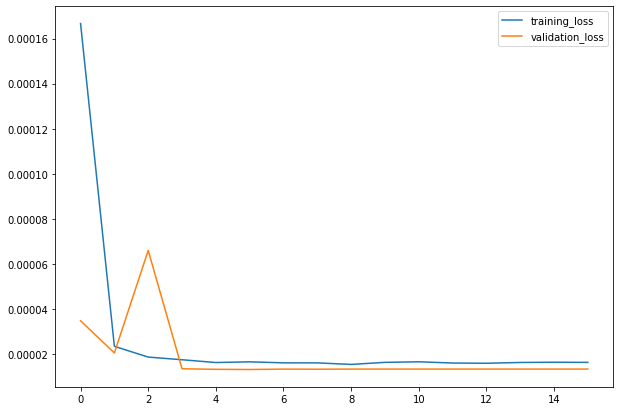

In [134]:
plot_history(history, zoom=False)

In [135]:
model_2_lstm.evaluate(X_test,y_test)

36/36 [==============================] - 0s 6ms/step - loss: 3.1286e-04 - mse: 3.1286e-04


[0.0003128593089058995, 0.0003128593089058995]

In [136]:
model_2_lstm.evaluate(X_train, y_train)

144/144 [==============================] - 1s 6ms/step - loss: 9.5601e-06 - mse: 9.5601e-06


[9.560055332258344e-06, 9.560055332258344e-06]

In [137]:
tf.keras.models.load_model('/content/model_experiments/model').evaluate(X_test, y_test)

36/36 [==============================] - 1s 6ms/step - loss: 3.1286e-04 - mse: 3.1286e-04


[0.0003128593089058995, 0.0003128593089058995]

In [138]:
def evaluate_preds(y_true, y_pred):

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}
     

In [139]:
y_pred_train = model_2_lstm.predict(X_train)
y_pred_test = model_2_lstm.predict(X_test)

36/36 [==============================] - 0s 5ms/step


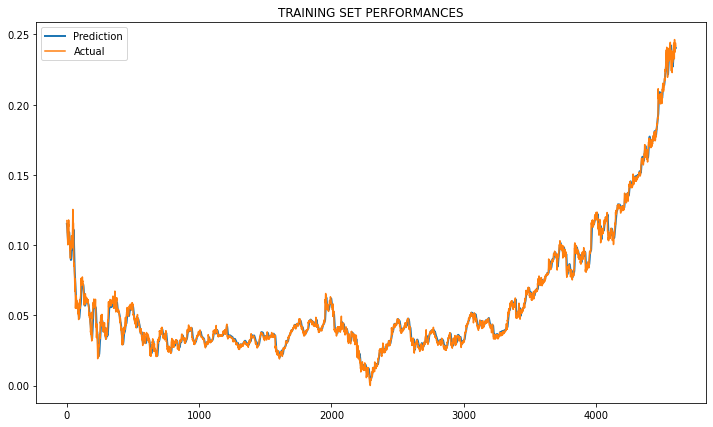

In [150]:
plt.figure(figsize=(12,7))
plt.title('TRAINING SET PERFORMANCES')
plt.plot(y_pred_train[:,0], label='Prediction', linewidth=2)
plt.plot(y_train, label='Actual')
plt.legend()
plt.show()


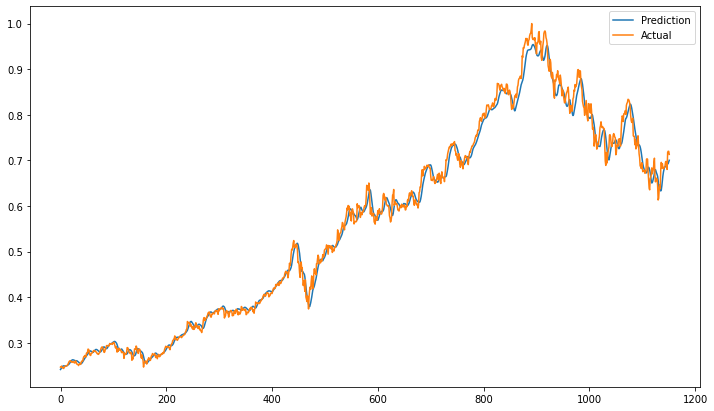

In [151]:
plt.figure(figsize=(12,7))
plt.plot(y_pred_test[:,0], label='Prediction')
plt.plot(y_test, label='Actual')
plt.legend()
plt.show()


In [142]:
y_test

array([0.24646009, 0.24622063, 0.24867534, ..., 0.71995206, 0.71977246,
       0.7130669 ])

In [143]:
y_pred_test[:,0]

array([0.24124876, 0.24289945, 0.24455084, ..., 0.6929642 , 0.69650644,
       0.70014524], dtype=float32)

In [149]:
evaluate_preds(y_train, y_pred_train[:,0])

{'mae': 0.0021263235,
 'mse': 9.560057e-06,
 'rmse': 0.0030919341,
 'mape': 1000.3813}

In [148]:
evaluate_preds(y_test, y_pred_test[:,0])

{'mae': 0.012659573,
 'mse': 0.0003128593,
 'rmse': 0.01768783,
 'mape': 2.1410263}